#  Histopathologic Cancer Detection – Project Introduction

The **Histopathologic Cancer Detection** dataset contains small image patches extracted from lymph node tissue slides. Each image is labeled to indicate the presence or absence of metastatic cancer.

### Dataset Overview:

- **Source**: [Kaggle - Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection)
- **Size**: 220,000+ labeled images
- **Format**: 96x96 pixel RGB .tif images
- **Labels**:
  - `1`: Cancer present
  - `0`: No cancer

### Objective:
To build a machine learning model—preferably using Convolutional Neural Networks (CNNs)—that can **accurately classify** whether an image contains cancerous cells. This has practical applications in assisting pathologists and improving early detection.

---

In the upcoming sections, we will perform:
- Exploratory Data Analysis (EDA)
- Visualization
- Data Preprocessing and Balancing
- Model Building (CNN and VGG)
- Hyperparameter Tuning
- Evaluation and Comparison


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np # linear algebra
from tensorflow.keras.preprocessing.image import load_img
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

2025-06-19 17:56:30.300452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750355790.557045      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750355790.632144      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
print(df.isnull().sum())
print(df.shape)
print(len(df))
print(df.duplicated().sum())

id       0
label    0
dtype: int64
(220025, 2)
220025
0


#  Exploratory Data Analysis (EDA) & Preprocessing

To better understand the histopathologic cancer detection dataset and prepare it for modeling, several key steps were undertaken:

##  Label Distribution Analysis
We began by examining the distribution of labels to identify any class imbalance between cancerous and non-cancerous samples. A value count and corresponding bar plot helped visualize the imbalance, confirming the need for balancing techniques to ensure fair model training.

##  Dataset Visualization
Sample images from both cancerous (label 1) and non-cancerous (label 0) classes were visualized. This provided an intuitive understanding of the visual patterns and variability across the dataset. It also helped highlight the importance of preprocessing and normalization before feeding data into models.

##  RGB Frequency Distribution
To explore the color composition of the tissue images, histograms of pixel intensity distributions were plotted for the red, green, and blue channels. This gave insight into the typical color ranges and helped in understanding how cancerous and non-cancerous tissues might differ visually.

##  Tissue Coverage Analysis
Tissue ratio was computed by converting images to grayscale and measuring how much of each image was covered by tissue (as opposed to background). Histograms of these tissue coverage values were created for both classes. This analysis helped determine whether cancerous images tend to have more or less visible tissue, which can influence feature extraction and model performance.

##  Data Balancing
Given the initial label imbalance, the dataset was balanced to include an equal number of cancerous and non-cancerous samples. This was essential to prevent the model from being biased toward the majority class.



In [4]:
df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

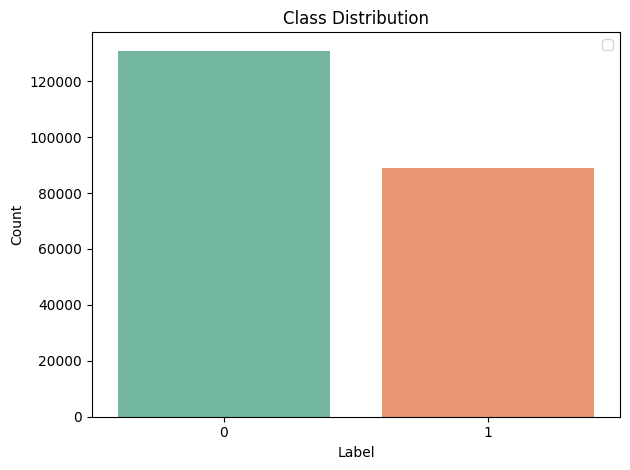

In [5]:
ax = sns.countplot(data=df, x='label', palette='Set2')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Non-Cancer', 'Cancer'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Since the dataset was highly imbalanced, I applied data balancing techniques to ensure a more stable and fair model training process, aiming to improve performance and reduce bias.

In [6]:
# separating the labels and making a smaller dataset with equal proportion of both.
df_pos=df[df['label']==1]
df_neg=df[df['label']==0]

df_pos=df_pos.sample(n=10000, random_state=42)
df_neg=df_neg.sample(n=10000, random_state=42)

df_balanced=pd.concat([df_pos,df_neg],axis=0)
df_balanced=df_balanced.sample(frac=1, random_state=42).reset_index(drop='True')

In [7]:
df_balanced

,id,label
0,b9b15ac3715fe63a9d6376a313ea25c62fa1b725,0
1,0a59def1f0ab78c248383d670d3e7186e4dcc9eb,1
2,d7c2dd385d281e416a27f32bcb133d10229ee6f9,1
3,a5b38657549b42d5654c621fc9c69b1595f63a09,1
4,38bb51a3def249ad9d6c47e8482917b0faaa788e,0
...,...,...
19995,68214ed190a1f8540710e9a7c140fcccf367e901,0
19996,2c1d5a831b4487b7bb5173ec08c4e40adc50f88c,0
19997,e56966eef7d0f9464dd4a18ac870699d077fde04,1
19998,0b6f4c071457e344c643f20ab0eb9dc4caf51026,1


Due to memory limitations on the Kaggle platform, running the model on the full dataset caused system crashes. To address this, I decided to work with a smaller, representative subset of the dataset to ensure smooth training and evaluation.
.

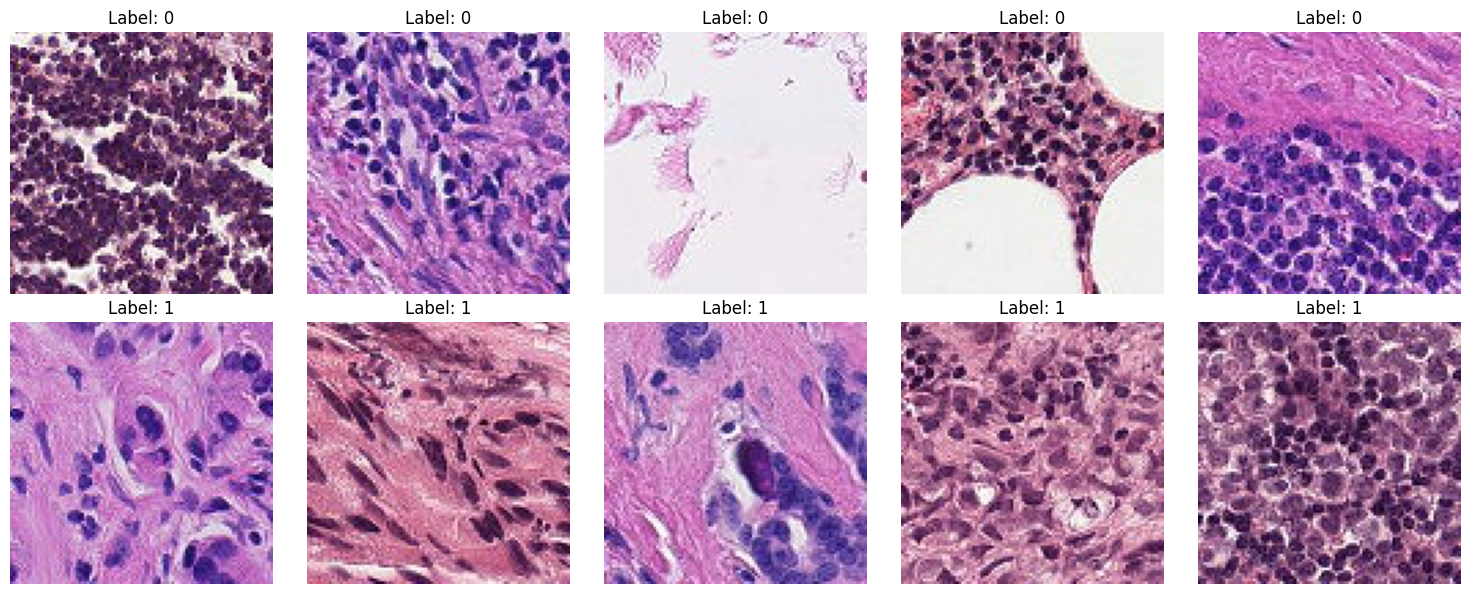

In [10]:
image_dir = '/kaggle/input/histopathologic-cancer-detection/train/'

# Show 5 random images from each class
n = 5
fig, axes = plt.subplots(2, n, figsize=(15, 6))

for label in [0, 1]:
    subset = df_balanced[df_balanced['label'] == label].sample(n=n, random_state=42)

    for i, image_id in enumerate(subset['id']):

        img_path = os.path.join(image_dir, f'{image_id}.tif')

        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            continue

        img = Image.open(img_path)

        ax = axes[label, i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Label: {label}')
        

plt.tight_layout()
plt.show()


Although it's difficult to draw definitive conclusions from a small sample of images, cancer-labeled patches appear to contain more tissue area and exhibit darker pixel intensities. To explore this further, I performed a pixel intensity distribution analysis and a tissue ratio distribution analysis to investigate potential differences between cancer and non-cancer classes.


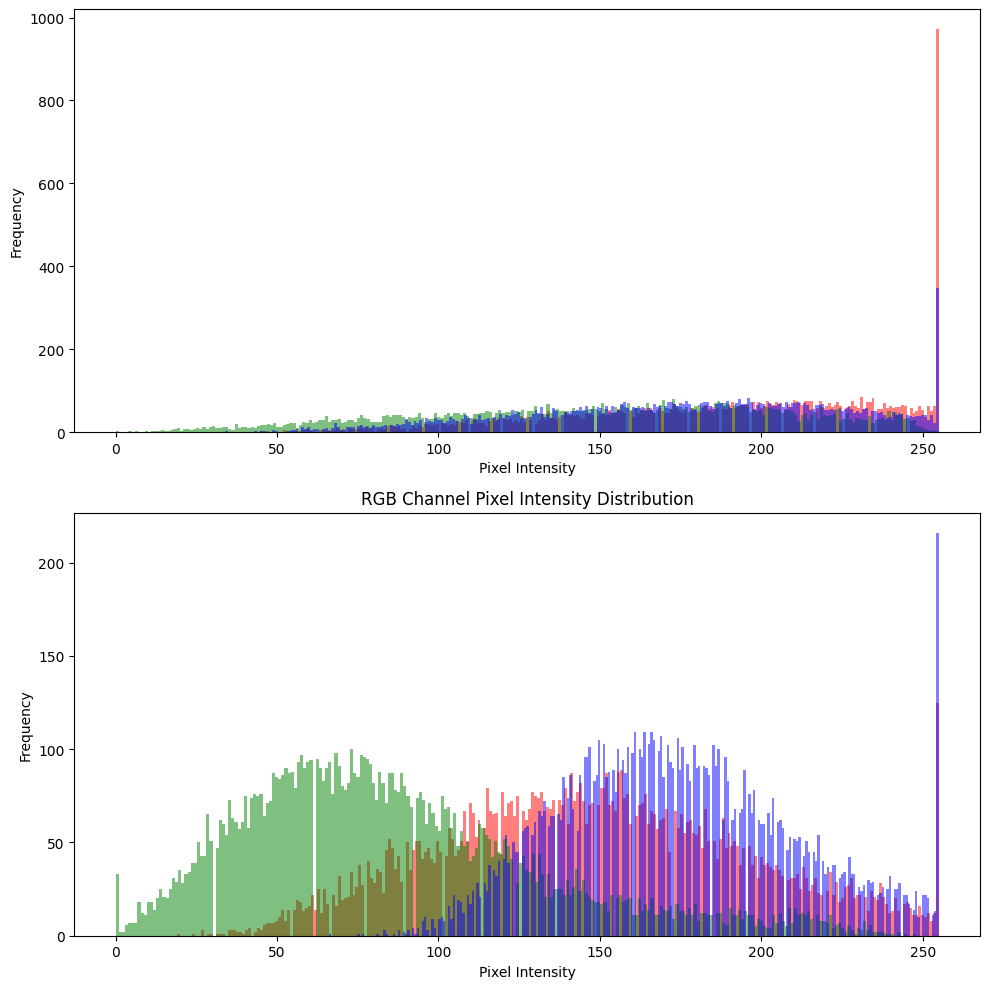

In [14]:
#taking pixel distribution of single sample of different categories and plotting a histogram.
image0_id=df_balanced[df_balanced['label']==0].sample(1).iloc[0]['id']
img0_path = os.path.join(image_dir, f'{image0_id}.tif')
image1_id=df_balanced[df_balanced['label']==1].sample(1).iloc[0]['id']
img1_path = os.path.join(image_dir, f'{image1_id}.tif')

img_0=Image.open(img0_path)
img_1=Image.open(img1_path)


img0=np.array(img_0)
img1=np.array(img_1)

fig, axes=plt.subplots(2,1,figsize=(10,10))
colors=['r', 'g', 'b']

for i, c in enumerate(colors):
    axes[0].hist(img0[:,:,i].ravel(), bins=256, color=c, alpha=0.5)


axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

    
for i, c in enumerate(colors):
    axes[1].hist(img1[:,:,i].ravel(), bins=256, color=c, alpha=0.5)

axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')


plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('RGB Channel Pixel Intensity Distribution')
plt.tight_layout()
plt.show()


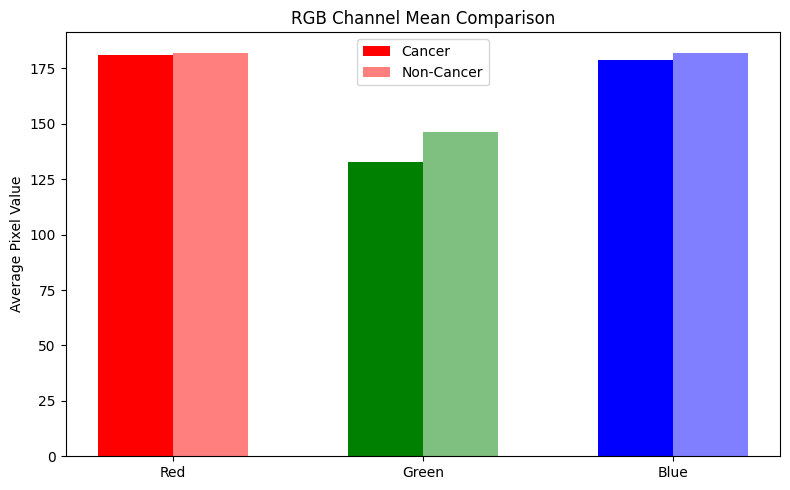

In [12]:
# Mean RGB Channel Distribution.
num_samples = 100  
cancer_ids = df_balanced[df_balanced['label'] == 1]['id'].sample(num_samples)
non_cancer_ids = df_balanced[df_balanced['label'] == 0]['id'].sample(num_samples)

def get_rgb_means(image_ids):
    rgb_means, tissue_ratios = [], []
    for img_id in image_ids:
        try:
            img_path = os.path.join(image_dir, img_id + '.tif')
            img = Image.open(img_path)
            img_gray = img.convert('L')
            img_np = np.array(img)
            img_gray_np = np.array(img_gray)

            mean_rgb = img_np.mean(axis=(0, 1))  # (R, G, B)
            rgb_means.append(mean_rgb)

            tissue_ratio = np.mean(img_gray_np < 200)
            tissue_ratios.append(tissue_ratio)
        except:
            continue
    return np.array(rgb_means), np.array(tissue_ratios)

# Compute RGB means and tissue ratios
cancer_means, cancer_tissue_ratios = get_rgb_means(cancer_ids)
non_cancer_means, non_cancer_tissue_ratios = get_rgb_means(non_cancer_ids)

# Plot RGB channel mean comparison
avg_cancer_rgb = cancer_means.mean(axis=0)
avg_non_cancer_rgb = non_cancer_means.mean(axis=0)
labels = ['Red', 'Green', 'Blue']
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.15, avg_cancer_rgb, width=0.3, color=['r', 'g', 'b'], label='Cancer')
plt.bar(x + 0.15, avg_non_cancer_rgb, width=0.3, color=['r', 'g', 'b'], alpha=0.5, label='Non-Cancer')

plt.xticks(x, labels)
plt.ylabel('Average Pixel Value')
plt.title('RGB Channel Mean Comparison')
plt.legend()
plt.tight_layout()
plt.show()

I performed an RGB pixel intensity frequency distribution and a comparison of mean values across RGB channels. The pixel intensity frequency distribution revealed a noticeable difference between cancer and non-cancer images, particularly in the overall spread and concentration of pixel values. However, the average values of the RGB channels did not show a significant distinction between the two classes, indicating that while individual pixel distributions vary, the mean color intensities remain relatively similar.


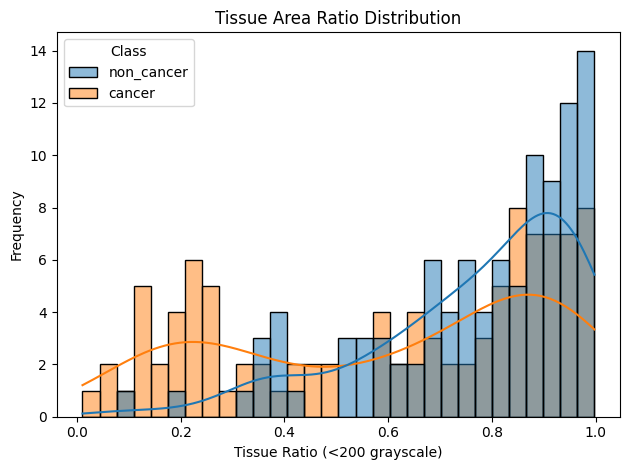

In [15]:
#Tissue Ratio Distribution
tissue = pd.DataFrame({
    'Tissue_ratio': np.concatenate([cancer_tissue_ratios, non_cancer_tissue_ratios]),
    'Class': ['non_cancer'] * len(cancer_tissue_ratios) + ['cancer'] * len(non_cancer_tissue_ratios)
})

# Plot tissue ratio histogram
sns.histplot(data=tissue, x='Tissue_ratio', hue='Class', bins=30, kde=True)
plt.title('Tissue Area Ratio Distribution')
plt.xlabel('Tissue Ratio (<200 grayscale)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

- **Cancerous images** generally showed a **higher tissue ratio**, indicating they often contain denser and more tissue-rich regions.
- **Non-cancerous images** exhibited more variability in tissue ratio, with many having lower values. This suggests the presence of more background or empty (non-tissue) areas in these samples.
- The **distribution of tissue ratio** across both classes helps highlight structural differences, which could be leveraged for preprocessing or feature extraction.
- These insights support the hypothesis that pixel intensity patterns and tissue density can offer meaningful signals for classification.


#  Data Preprocessing

Before training any model, it was important to preprocess the data to ensure consistency, reduce computational complexity, and optimize performance. The preprocessing steps included:

##  Image Preparation
Each image ID in the dataset was used to load the corresponding `.tif` image file. These images were read and converted into NumPy arrays for efficient handling. The images were then normalized by scaling pixel values to the range [0, 1], which helps in faster convergence during training and stabilizes the gradients.

##  Label Formatting
Along with the images, their associated labels (cancerous or not) were extracted and converted into a NumPy array. This ensures compatibility with the training process and aligns each label with its corresponding image data.

##  Dataset Splitting
After balancing the dataset to address class imbalance, the full dataset was split into training and testing sets. The training set was used for learning model parameters, while the testing set was used for evaluating generalization performance. A validation set was also derived during training to monitor model performance and prevent overfitting.

This structured approach to preprocessing ensured that the data fed into the models was clean, well-formatted, and representative of both classes, laying the groundwork for effective learning.


In [25]:
#Getting image pixel array and normalizing them so there are ready to be passed into the model.
df_sample=df_balanced['id'].to_list()

paths=[os.path.join(image_dir,f'{id}.tif') for id in df_sample]
images=[np.array(Image.open(path) )/255 for path in paths]
df_sample1=df_balanced['label'].to_list()
df_sample1=np.array(df_sample1)

images_array = np.array(images)


In [26]:
# Splitting the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    images_array, df_sample1, test_size=0.2, random_state=42, stratify=df_sample1
)


#  Model Architecture and Training

To efficiently handle the large image dataset, data generators were employed to create batches of images and labels on-the-fly during training. This approach helped in managing memory usage and allowed seamless feeding of data to the models without loading the entire dataset into memory at once.

Two different convolutional neural network (CNN) architectures were utilized for classification:

- **Basic CNN Model:** A custom-built lightweight convolutional neural network designed to capture important spatial features from the histopathologic images.
- **VGGNet:** A deeper and more complex pretrained architecture known for its excellent performance in image recognition tasks.

Both models were trained on the training data generator and validated using a separate validation data generator. The training process included monitoring of accuracy and loss metrics to evaluate learning progress. Additionally, Receiver Operating Characteristic (ROC) curves were plotted to assess the trade-off between sensitivity and specificity of the models.

This training framework allowed for a robust comparison between the basic CNN and VGGNet architectures, facilitating informed decisions on model selection and optimization.

### Initial Hyperparameters and Callbacks:
- **EarlyStopping:** Monitored training loss with a patience of 3 epochs.
- **ReduceLROnPlateau:** Monitored training loss, reduced learning rate by a factor of 0.2 after 3 epochs without improvement, with a minimum learning rate of 1e-6.
- **ModelCheckpoint:** Saved the best model based on training loss.

Training was performed for 5 epochs with these settings.


Due to limited RAM availability on Kaggle, loading the entire dataset into memory is not feasible. To handle this efficiently, I used `ImageDataGenerator` to create data generators that load images in batche


In [21]:
Batch_size=16

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator()
train_data=datagen.flow(X_train,y_train,batch_size=Batch_size, shuffle=True)

datagen1=ImageDataGenerator()
val_data=datagen1.flow(X_test,y_test,batch_size=Batch_size, shuffle=False)

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_basic(input_shape=(96, 96, 3)):
    model = models.Sequential(name="Basic_Model")
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

basic_model = build_basic()
basic_model.summary()

Model: "Basic_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          73,729 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,881 (292.50 KB)

 Trainable params: 74,753 (292.00 KB)

 Non-trainable params: 128 (512.00 B)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC  # Better to import from tensorflow.keras

early_stop = EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='loss',
    save_best_only=True,
    save_weights_only=False
)

In [30]:
from keras.metrics import AUC


basic_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy',AUC()] )
history = basic_model.fit(train_data, epochs=5, steps_per_epoch=len(X_train)//16, validation_data= val_data, validation_steps= len(X_test)//16, callbacks=[early_stop, reduce_lr, checkpoint])

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 100s 97ms/step - accuracy: 0.6899 - auc: 0.7400 - loss: 1.1888 - val_accuracy: 0.5782 - val_auc: 0.7843 - val_loss: 1.5648 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 95s 95ms/step - accuracy: 0.8131 - auc: 0.8863 - loss: 0.4422 - val_accuracy: 0.7032 - val_auc: 0.7946 - val_loss: 0.6548 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 93ms/step - accuracy: 0.8466 - auc: 0.9215 - loss: 0.3585 - val_accuracy: 0.6933 - val_auc: 0.8102 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 92ms/step - accuracy: 0.8816 - auc: 0.9466 - loss: 0.2952 - val_accuracy: 0.7510 - val_auc: 0.8223 - val_loss: 0.6673 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 90s 90ms/step - accuracy: 0.8892 - auc: 0.9570 - loss: 0.2652 - val_accuracy: 0.6852 - val_auc: 0.8071 - val_loss: 1.0296 - learning_rate: 0.0010


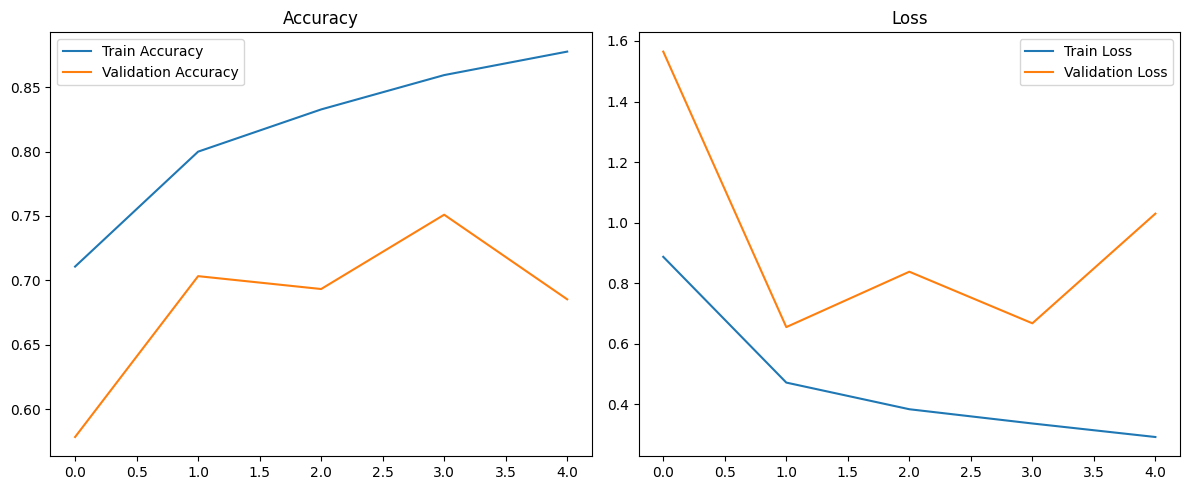

In [31]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


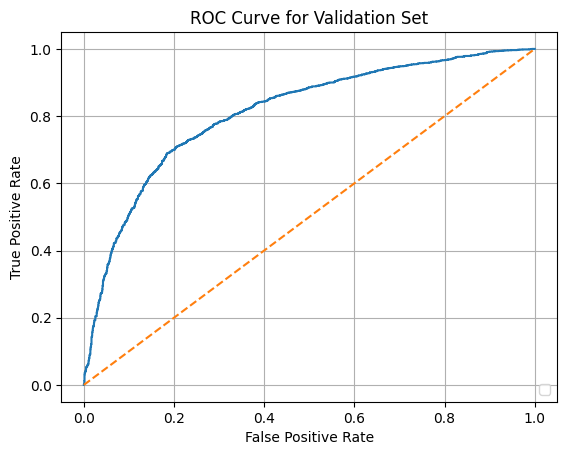

In [32]:
from sklearn.metrics import roc_curve, auc

y_pred=basic_model.predict(val_data)
fpr,tpr,_=roc_curve(y_test, y_pred)
roc_auc=auc(fpr,tpr)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
plt.show()


###  Basic CNN Model Performance Analysis

The basic CNN model showed a strong ability to fit the training data, with training **accuracy increasing** from **68.9% to 88.9%**, and **AUC** improving from **0.74 to 0.957** over 5 epochs. However, its performance on the validation set was **inconsistent and less impressive**.

- **Validation accuracy** ranged between **68% and 75%**, indicating moderate classification performance.
- **Validation AUC** peaked at **0.8223**, suggesting the model had some capacity to distinguish between the classes.
- However, the **validation loss** was highly unstable—starting at **1.56**, briefly dropping to **0.65**, and then increasing again to **1.03**—which points toward **overfitting**.
- The model quickly memorized the training data but failed to generalize well on unseen data.

These results highlight that while the model learned patterns from the training data, it **did not generalize effectively**. This motivates further tuning and trying more complex architectures like **VGGNet**, and potentially applying regularization techniques or improved data preprocessing strategies.


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64


dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 92, 92, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 42, 42, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       7,225,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,291,425 (27.81 MB)

 Trainable params: 7,291,425 (27.81 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy',AUC()] )
history1=model.fit(train_data, epochs=5, steps_per_epoch=len(X_train)//16, validation_data= val_data, validation_steps= len(X_test)//16, callbacks=[early_stop, reduce_lr, checkpoint])

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 309s 306ms/step - accuracy: 0.6848 - auc_1: 0.7445 - loss: 0.6268 - val_accuracy: 0.7665 - val_auc_1: 0.8634 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 303s 303ms/step - accuracy: 0.7870 - auc_1: 0.8580 - loss: 0.4709 - val_accuracy: 0.7885 - val_auc_1: 0.8710 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 305s 305ms/step - accuracy: 0.7972 - auc_1: 0.8703 - loss: 0.4530 - val_accuracy: 0.7663 - val_auc_1: 0.8882 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 300s 300ms/step - accuracy: 0.8030 - auc_1: 0.8836 - loss: 0.4321 - val_accuracy: 0.8075 - val_auc_1: 0.8904 - val_loss: 0.4208 - learning_rate: 0.0010
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 300s 300ms/step - accuracy: 0.8249 - auc_1: 0.9028 - loss: 0.3995 - val_accuracy: 0.8055 - val_auc_1: 0.8870 - val_loss: 0.4272 - learning_rate: 0.0010


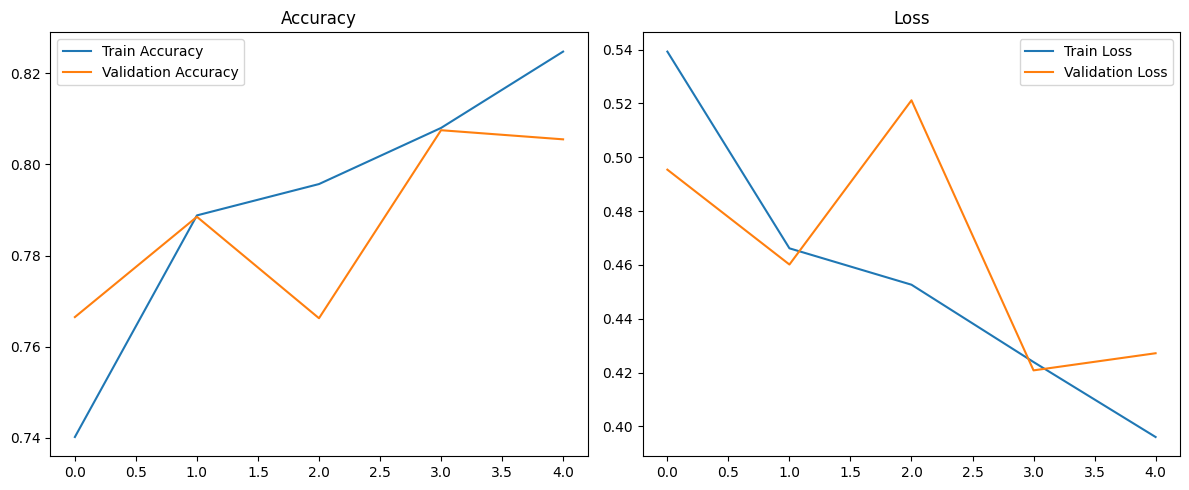

In [36]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot Accuracy
axes[0].plot(history1.history['accuracy'], label='Train Accuracy')
axes[0].plot(history1.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot Loss
axes[1].plot(history1.history['loss'], label='Train Loss')
axes[1].plot(history1.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step


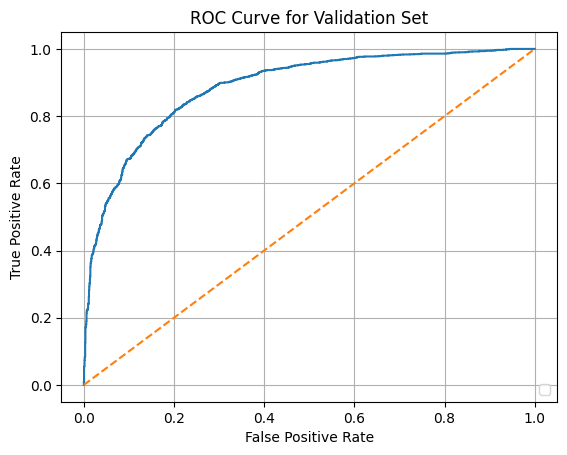

In [37]:
y_pred=model.predict(val_data)
fpr,tpr,_=roc_curve(y_test, y_pred)
roc_auc=auc(fpr,tpr)

plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
plt.show()


### VGGNet Model - Initial Training Results (Without Tuning)

The initial VGG-based model was trained for 5 epochs with default hyperparameters. The results were as follows:

- **Training Accuracy** improved from **68% to 82%**
- **Training AUC** increased from **0.74 to 0.90**
- **Validation Accuracy** peaked at **80.7%**
- **Validation AUC** rose to **0.89**
- **Validation Loss** showed improvement but remained inconsistent

** Observations:**
- The model performed well out-of-the-box and showed learning progression.
- Validation performance, although decent, fluctuated — indicating potential overfitting or insufficient regularization.
- The model had not yet fully converged, suggesting the need for additional training or hyperparameter adjustments.

# Hyperparameter Tuning and Callbacks

To improve model training and prevent overfitting, I updated the callbacks to monitor the validation loss (`val_loss`) instead of the training loss. This shift ensures that early stopping, learning rate reduction, and model checkpointing are based on how well the model generalizes to unseen data, not just how well it fits the training data.

- **EarlyStopping:** Stops training if validation loss doesn't improve for 3 consecutive epochs and restores the best weights.
- **ReduceLROnPlateau:** Reduces the learning rate by a factor of 0.2 if validation loss plateaus for 2 epochs, allowing the model to fine-tune better.
- **ModelCheckpoint:** Saves the best model based on validation loss during training.

Additionally, I increased the number of training epochs from 5 to 7 to give the model more opportunities to learn, while relying on early stopping to avoid overfitting.

This setup helps the model train more efficiently and improves its ability to generalize on new data.


In [38]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)


In [64]:
history2=model.fit(train_data, epochs=10, steps_per_epoch=len(X_train)//16, validation_data= val_data, validation_steps= len(X_test)//16, callbacks=[early_stop, reduce_lr, checkpoint])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 350s 350ms/step - accuracy: 0.8298 - auc_1: 0.9104 - loss: 0.3828 - val_accuracy: 0.8175 - val_auc_1: 0.9059 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 357s 357ms/step - accuracy: 0.8553 - auc_1: 0.9280 - loss: 0.3438 - val_accuracy: 0.8317 - val_auc_1: 0.9044 - val_loss: 0.4105 - learning_rate: 0.0010
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 357s 357ms/step - accuracy: 0.8680 - auc_1: 0.9413 - loss: 0.3122 - val_accuracy: 0.8163 - val_auc_1: 0.8953 - val_loss: 0.4186 - learning_rate: 0.0010
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 350s 350ms/step - accuracy: 0.8952 - auc_1: 0.9641 - loss: 0.2459 - val_accuracy: 0.8357 - val_auc_1: 0.9131 - val_loss: 0.4028 - learning_rate: 2.0000e-04
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 349s 349ms/step - accuracy: 0.9117 - auc_1: 0.9722 - loss: 0.2159 - val_accuracy: 0.8422 - val_auc_1: 0.9092 - val_loss: 0.4459 - learning_rate: 2.0000e-04
Epoch 6/10
1000/1000 ━

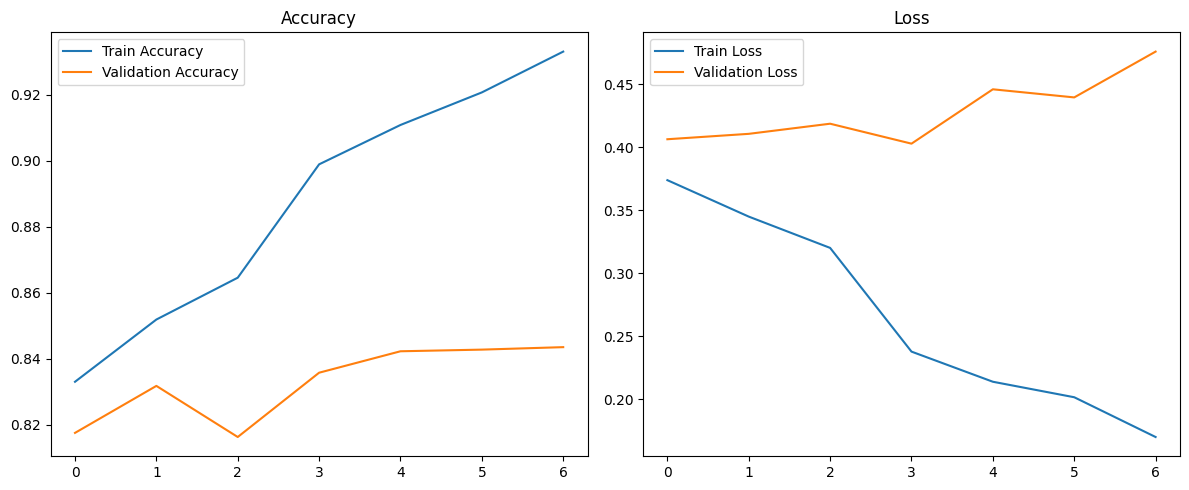

In [74]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot Accuracy
axes[0].plot(history2.history['accuracy'], label='Train Accuracy')
axes[0].plot(history2.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot Loss
axes[1].plot(history2.history['loss'], label='Train Loss')
axes[1].plot(history2.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


###  VGGNet - After Hyperparameter Tuning

To improve generalization and model performance, the following hyperparameters were introduced:

- `EarlyStopping(monitor='val_loss', patience=3)`
- `ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)`
- `ModelCheckpoint(monitor='val_loss', save_best_only=True)`
- Training increased to **10 epochs**

** Why monitor `val_loss` instead of `loss`?**

Monitoring `val_loss` (validation loss) provides a better signal of the model’s ability to generalize to unseen data. While `loss` reflects training performance, it may continue improving even when the model starts overfitting. In contrast, increasing `val_loss` usually indicates that the model is no longer improving on new data, making it a more reliable metric for early stopping and learning rate adjustment.

**Training Outcomes:**

- **Training Accuracy** rose from **83% to 93%**
- **Training AUC** increased to **0.98**
- **Validation Accuracy** peaked at **84.3%**
- **Validation AUC** remained consistently high (> 0.90)
- **Validation Loss** remained stable and low, showing better generalization

** Conclusion:**
- Hyperparameter tuning led to improved convergence and validation performance.
- Monitoring `val_loss` helped prevent overfitting and allowed for early stopping based on generalization.
- The tuned VGGNet model exhibited more stable and reliable metrics, making it suitable for final evaluation and submission.


 #  Final Model Training Comparison

To evaluate model progression and effectiveness, I trained and compared three model configurations:

1. **Baseline CNN Model**
2. **VGG-style CNN Model**
3. **VGG-style CNN with Callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)**

---

###  1. Baseline CNN Model

- The initial CNN model showed a sharp improvement in training accuracy and AUC.
- However, it quickly began to overfit: the validation loss increased even as training metrics improved.
- **Best validation accuracy** was **~75.1%**, but validation loss and AUC were inconsistent.

---

###  2. VGG-style CNN Model 

- A deeper VGG-inspired model performed better, with improved generalization.
- Training and validation accuracy rose steadily with better AUC scores.
- However, without any regularization or monitoring, the model was still prone to overfitting by later epochs.
- Introduced **EarlyStopping**, **ReduceLROnPlateau**, and **ModelCheckpoint**.
- **Best validation accuracy** was **~80.5%**, and **AUC** reached **0.89**.

---

###  3. VGG + Hyperparameter Tuning (Final Model)

- Tuned **EarlyStopping**, **ReduceLROnPlateau**, and **ModelCheckpoint**.
- Crucially, monitored `val_loss` instead of training loss to better track generalization.
- This configuration achieved the most stable results, with improved convergence and reduced overfitting.
- **Best validation accuracy**: **84.35%**
- **Best validation AUC**: **0.9131**

---

##  Summary Table

| Model                             | Best Val Accuracy | Best Val AUC | Val Loss Trend         | Notes                                 |
|----------------------------------|-------------------|---------------|-------------------------|----------------------------------------|
| **Baseline CNN**                 | ~75.1%            | 0.8223        | Fluctuating             | Overfitting, no regularization         |
| **VGG-style CNN (No Callbacks)** | ~80.5%            | 0.8904        | Slightly noisy          | Deeper model improved performance      |
| **VGG + Callbacks (Final)**      | **84.35%**        | **0.9131**    | Smooth, consistent drop | Best results; callbacks helped greatly |

---

**Conclusion**: Adding callbacks and monitoring `val_loss` proved crucial in improving validation performance and achieving a more generalizable model. The final configuration demonstrated the best stability and accuracy.


In [20]:
# import os
# import pandas as pd
# import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import load_model

# # Paths
# test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
# model_path = 'best_model.h5'  # Make sure your model is saved with this name

# # 1. Create DataFrame of test image filenames
# test_ids = sorted(os.listdir(test_dir))
# test_df = pd.DataFrame({'filename': test_ids})

# # 2. Set up ImageDataGenerator for test images
# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_dataframe(
#     dataframe=test_df,
#     directory=test_dir,
#     x_col='filename',
#     y_col=None,
#     target_size=(96, 96),   # Change to your model's input size
#     color_mode='rgb',       # Use 'grayscale' if needed
#     class_mode=None,
#     batch_size=64,
#     shuffle=False
# )

# # 3. Load the trained model
# model = load_model(model_path)

# # 4. Predict
# preds = model.predict(test_generator, steps=int(np.ceil(len(test_generator))))
# predictions = (preds > 0.5).astype(int).flatten()

# # 5. Create and save submission
# submission = pd.DataFrame({
#     'id': test_df['filename'].str.replace('.tif', '', regex=False),
#     'label': predictions
# })

# submission.to_csv('submission.csv', index=False)
# print("✅ Submission file saved as 'submission.csv'.")
